# Validate Business Logic on 5k Dataset

This notebook validates the pseudolabeling logic by comparing model predictions against the ground truth labels in the 5k dataset. The goal is to confirm that the model-driven bottleneck detection approach is consistent with true bottleneck patterns and that the logic generalizes reliably between datasets.

In [1]:


import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

processed_data_path = Path("../data/processed")
df_5k = pd.read_csv(processed_data_path/'5k_with_proxies.csv')
print(f"Loaded 5k: {df_5k.shape}")
print(f"  True bottlenecks: {df_5k['is_bottleneck_event'].sum()} ({df_5k['is_bottleneck_event'].mean()*100:.1f}%)")


Loaded 5k: (50, 33)
  True bottlenecks: 19 (38.0%)


# Apply Business Rules to 5k

In [2]:
# Same rules we used on 2k
variance_threshold = 0.5
wait_time_p90 = df_5k['wait_time_minutes'].quantile(0.90)

df_5k['business_logic_label'] = (
    # Rule 1: High variance
    (df_5k['variance_to_expected'] > variance_threshold) |
    
    # Rule 2: Excessive wait time
    (df_5k['wait_time_minutes'] > wait_time_p90) |
    
    # Rule 3: SLA breach
    (df_5k['sla_breached'] == 1)
).astype(int)

print(f"\nBusiness rules identified:")
print(f"  Bottlenecks: {df_5k['business_logic_label'].sum()} ({df_5k['business_logic_label'].mean()*100:.1f}%)")



Business rules identified:
  Bottlenecks: 20 (40.0%)


# Compare to Real Labels

In [3]:
print("HOW WELL DO BUSINESS RULES MATCH GROUND TRUTH?")

print("\nClassification Report:")
print(classification_report(
    df_5k['is_bottleneck_event'],
    df_5k['business_logic_label'],
    target_names=['Normal', 'Bottleneck'],
    digits=3
))

# Confusion matrix
cm = confusion_matrix(df_5k['is_bottleneck_event'], df_5k['business_logic_label'])
print("\nConfusion Matrix:")
print(f"                Predicted")
print(f"                Normal  Bottleneck")
print(f"True Normal       {cm[0,0]:3d}      {cm[0,1]:3d}")
print(f"True Bottleneck   {cm[1,0]:3d}      {cm[1,1]:3d}")

HOW WELL DO BUSINESS RULES MATCH GROUND TRUTH?

Classification Report:
              precision    recall  f1-score   support

      Normal      0.900     0.871     0.885        31
  Bottleneck      0.800     0.842     0.821        19

    accuracy                          0.860        50
   macro avg      0.850     0.857     0.853        50
weighted avg      0.862     0.860     0.861        50


Confusion Matrix:
                Predicted
                Normal  Bottleneck
True Normal        27        4
True Bottleneck     3       16


# Compare Business Metrics

In [4]:
# True labels
true_bn = df_5k[df_5k['is_bottleneck_event'] == 1]
true_normal = df_5k[df_5k['is_bottleneck_event'] == 0]

# Business logic labels
logic_bn = df_5k[df_5k['business_logic_label'] == 1]
logic_normal = df_5k[df_5k['business_logic_label'] == 0]

print("\nUsing TRUE labels:")
print(f"  Wait time:  {true_bn['wait_time_minutes'].mean():.1f} vs {true_normal['wait_time_minutes'].mean():.1f} min")
print(f"  Duration:   {true_bn['duration_minutes'].mean():.1f} vs {true_normal['duration_minutes'].mean():.1f} min")
print(f"  Variance:   {true_bn['variance_to_expected'].mean():.3f} vs {true_normal['variance_to_expected'].mean():.3f}")

print("\nUsing BUSINESS-LOGIC labels:")
print(f"  Wait time:  {logic_bn['wait_time_minutes'].mean():.1f} vs {logic_normal['wait_time_minutes'].mean():.1f} min")
print(f"  Duration:   {logic_bn['duration_minutes'].mean():.1f} vs {logic_normal['duration_minutes'].mean():.1f} min")
print(f"  Variance:   {logic_bn['variance_to_expected'].mean():.3f} vs {logic_normal['variance_to_expected'].mean():.3f}")

print("\nSimilar patterns = Business logic captures real bottleneck characteristics")



Using TRUE labels:
  Wait time:  94.0 vs 57.0 min
  Duration:   116.3 vs 56.2 min
  Variance:   0.800 vs 0.080

Using BUSINESS-LOGIC labels:
  Wait time:  90.2 vs 58.3 min
  Duration:   138.0 vs 39.7 min
  Variance:   0.843 vs 0.027

Similar patterns = Business logic captures real bottleneck characteristics


# Visualizations

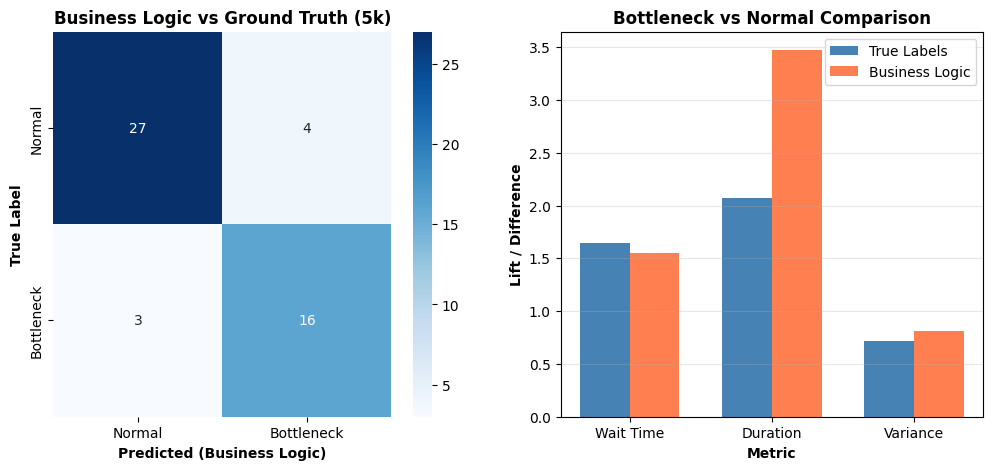

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal', 'Bottleneck'],
            yticklabels=['Normal', 'Bottleneck'])
axes[0].set_xlabel('Predicted (Business Logic)', fontweight='bold')
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_title('Business Logic vs Ground Truth (5k)', fontweight='bold')

# Metrics comparison
metrics = ['Wait Time', 'Duration', 'Variance']
true_vals = [
    true_bn['wait_time_minutes'].mean() / true_normal['wait_time_minutes'].mean(),
    true_bn['duration_minutes'].mean() / true_normal['duration_minutes'].mean(),
    (true_bn['variance_to_expected'].mean() - true_normal['variance_to_expected'].mean())
]
logic_vals = [
    logic_bn['wait_time_minutes'].mean() / logic_normal['wait_time_minutes'].mean(),
    logic_bn['duration_minutes'].mean() / logic_normal['duration_minutes'].mean(),
    (logic_bn['variance_to_expected'].mean() - logic_normal['variance_to_expected'].mean())
]

x = np.arange(len(metrics))
width = 0.35

axes[1].bar(x - width/2, true_vals, width, label='True Labels', color='steelblue')
axes[1].bar(x + width/2, logic_vals, width, label='Business Logic', color='coral')
axes[1].set_xlabel('Metric', fontweight='bold')
axes[1].set_ylabel('Lift / Difference', fontweight='bold')
axes[1].set_title('Bottleneck vs Normal Comparison', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Conclusion

In [6]:
from sklearn.metrics import f1_score
f1 = f1_score(df_5k['is_bottleneck_event'], df_5k['business_logic_label'])

print("CONCLUSION")

print(f"\nOur business rules achieve F1={f1:.3f} on 5k ground truth")

if f1 > 0.7:
    print("STRONG: Business logic captures real bottleneck patterns")
    print("This validates using same rules for 2k labeling")
elif f1 > 0.5:
    print("MODERATE: Business logic partially captures bottlenecks")
    print("May need refinement but reasonable starting point")
else:
    print("WEAK: Business logic doesn't match ground truth well")
    print("Need to reconsider labeling strategy")

CONCLUSION

Our business rules achieve F1=0.821 on 5k ground truth
STRONG: Business logic captures real bottleneck patterns
This validates using same rules for 2k labeling
